 ### Basic Trading System 
 We implement a basic trading system, which can be used for backtesting algorithmic trading strategies.
 To start create a new instance of ```TradingSystem()```.
 The basic functionality is as follow:
* Add financial data to the data feed using `TradingSystem.DownloadData(ticker,startDate,endDate)`. Currently the data is provided only using ```yahooFinance```.

* Set a strategy to be used in the backtesting process. A new strategy can be defined by defining a new class inheriting  from `Strategy` and overwriting `OnBar()`. The function `OnBar()` is performed once a day during a backtest and allows to create buy and sell orders.
* Set the initial amount of money available in the portfolio using `TradingSystem.portfolio.SetInitialCash(cash)`.
* Perform a backtest of the strategy, using the given data, with `TradingSystem.Run()`.

* Analyze the backtest using various statistics, which are provided by `TradingSystem.GetStats()`. Additionally  `TradingSystem.log` keeps track of the value of the portfolio over time and can be used to plot the portfolio.


The following showcases the usage of Basic Trading System and implements a toy strategy: Buy a stock on one day and sell it the next day.


In [1]:
import sys
sys.path.append("../TradingSystem") # go to parent dir

In [2]:
from TradingSystem import *
# Ignore panda warnings
import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import yfinance as yf
from datetime import datetime
import backtrader as bt

[*********************100%%**********************]  1 of 1 completed
100%|██████████| 2019/2019 [00:00<00:00, 39119.61it/s]


Starting Portfolio Value: 10000.00
Final Portfolio Value: 10012.40


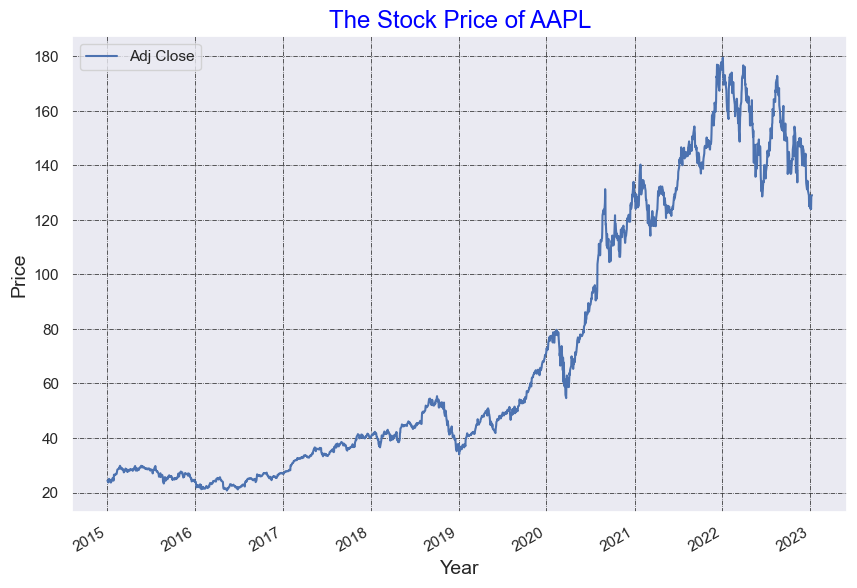

ROI 0.12402231216430692
Annualized Volatility 0.002044267116317015
Max Drawdown -0.006399725578119612
Annualized Sharpe 0.07673502636695796
The first ten trades:
<Trade: 2015-01-05 00:00:00 AAPL 1@23.7147216796875>
<Trade: 2015-01-06 00:00:00 AAPL 1@23.716949462890625>
<Trade: 2015-01-07 00:00:00 AAPL 1@24.049516677856445>
<Trade: 2015-01-08 00:00:00 AAPL 1@24.97355842590332>
<Trade: 2015-01-09 00:00:00 AAPL 1@25.000341415405273>
<Trade: 2015-01-12 00:00:00 AAPL 1@24.38431167602539>
<Trade: 2015-01-13 00:00:00 AAPL 1@24.600814819335938>
<Trade: 2015-01-14 00:00:00 AAPL 1@24.50707244873047>
<Trade: 2015-01-15 00:00:00 AAPL 1@23.841936111450195>
<Trade: 2015-01-16 00:00:00 AAPL 1@23.65669059753418>


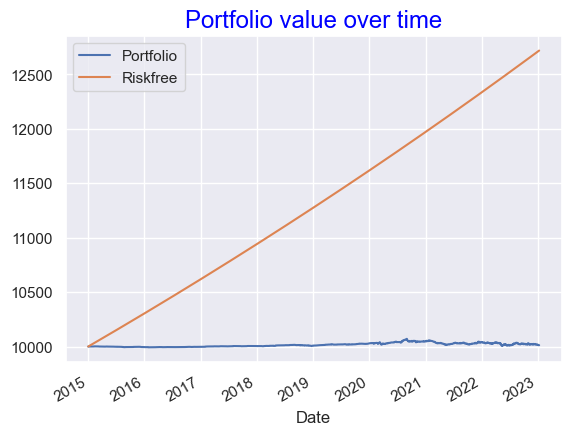

In [4]:
# Load Apple data from Jan 1,2015 to Jan 10, 2023
ticker = 'AAPL'
startDate = "2015-01-01"
endDate = "2023-01-10"

# Initialize the trading system
trader = TradingSystem()
# Add the Apple data to the trading system
trader.DownloadData(ticker, startDate, endDate)
# Set the strategy of the trading system to a naive strategy
# where we buy on one day and sell on the next day
trader.SetStrategy(BasicStrategy())
# The portfolio starts with $10000 
trader.portfolio.SetInitialCash(10000)


 
 # Perform a backtest for the basic trading strategy  
trader.Run()




print('Starting Portfolio Value: %.2f' % trader.portfolio.initialCash)
print('Final Portfolio Value: %.2f' % trader.portfolio.cash)

# Show the stock price history
PlotStockData(ticker, (trader.datas[ticker])['Adj Close'])


# Analyze the backtest by providing various statistics
trader.GetStats()


# Show the first ten trades during the backtest
print('The first ten trades:')
for trade in trader.strategy.trades[:10]:
    print(trade)


# Show the portfolio value over time
trader.log.plot()
plt.title("Portfolio value over time",size='x-large',color='blue')
plt.show()

### Simple moving average crossing
We now implement a basic simple moving average crossing strategy, where we calculate two moving averages, one over a 10day window (the fast window) and one over a 30day window(the slow window).
At every day we compute the slope of the moving average as an indicator for the direction of the stock price.
If the fast moving average crosses upwards through the slow moving average we produce a buy signal and vice versa, if the fast moving averages drosses downwards we produce a sell  signal.


[*********************100%%**********************]  1 of 1 completed
100%|██████████| 1005/1005 [00:00<00:00, 1559.31it/s]


Portfolio: 
Cash value: 9947.631679534912
Ticker:MSFT, Size:1

ROI 0.4261445236205974
Annualized Volatility 0.0012049565036018248
Max Drawdown -0.0014420996040058615
Annualized Sharpe 0.8863893976796251
Starting Portfolio Value: 10000.00
Final Portfolio Value: 10042.61


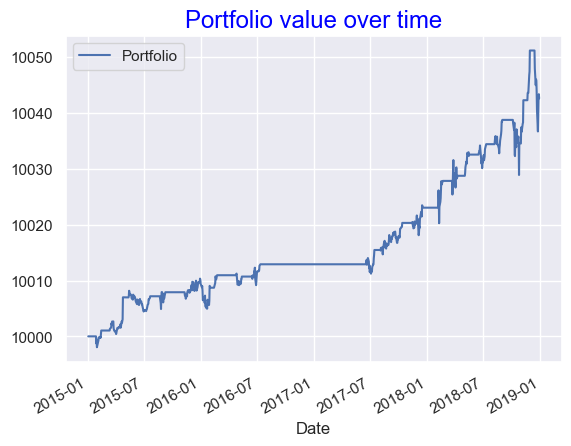

In [5]:
# Load Microsoft data from Jan 01, 2021 to Jan 10, 2021
ticker = 'MSFT'
startDate = "2015-01-01"
endDate = "2018-12-31"

trader = TradingSystem()
# Load the Microsoft data ino the trading system
trader.DownloadData(ticker, startDate, endDate)
# Set the strategy to the simple moving average crossing strategy
trader.SetStrategy(SMACross())
trader.portfolio.SetInitialCash(10000)

# Run the trader
trader.Run()

# Print the portfolio information
print(trader.portfolio)

# Get statistics from the trader
trader.GetStats()

# Print the starting and final portfolio values
print('Starting Portfolio Value: %.2f' % trader.portfolio.initialCash)
print('Final Portfolio Value: %.2f' % trader.GetPortfolioValue())

# Plot the portfolio value over time
trader.log[['Portfolio']].plot()
plt.title("SMA: Portfolio value over time", size='x-large', color='blue')
plt.show()

### Backtrader cross check
To cross check our backtest we compare it to a backtest of a SMA crossover strategy with backtrader (with the same fast and slow window). The results show a small discrepancy due to our slightly different implementation of crossovers.


In [6]:
# Create a subclass of Strategy to define the indicators and logic
class SmaCross(bt.Strategy):
    # List of parameters which are configurable for the strategy
    params = dict(
        pfast=10,  # Period for the fast moving average
        pslow=30   # Period for the slow moving average
    )

    def __init__(self):
        sma1 = bt.ind.SMA(period=self.p.pfast)  # Fast moving average
        sma2 = bt.ind.SMA(period=self.p.pslow)  # Slow moving average
        self.crossover = bt.ind.CrossOver(sma1, sma2)  # Crossover signal

    def next(self):
        if not self.position:  # Not in the market
            if self.crossover > 0:  # If fast crosses slow to the upside
                self.buy()  # Enter long

        elif self.crossover < 0:  # In the market & cross to the downside
            self.close()  # Close long position

cerebro = bt.Cerebro()  # Create a "Cerebro" engine instance

# Create a data feed
data = bt.feeds.PandasData(dataname=yf.download("MSFT", start="2015-01-01", end="2018-12-31"))

cerebro.adddata(data)  # Add the data feed

cerebro.addstrategy(SmaCross)  # Add the trading strategy
cerebro.broker.setcash(10000.0)
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

cerebro.run()  # Run it all
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

[*********************100%%**********************]  1 of 1 completed

Starting Portfolio Value: 10000.00
Final Portfolio Value: 10028.65


### Analysis of pairs
Given a pair of assets (here we compare Bitcoin and Ethereum) we analyze the spread over time to determine a basic trading in pair strategy. We compare the simple and exponential moving average.
In the file ```TradingPairsExample.ipynb``` we go beyond and will perform an in-depth anlaysis of suitable pairs as well as the implementation of a basic pairs trading strategy.

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


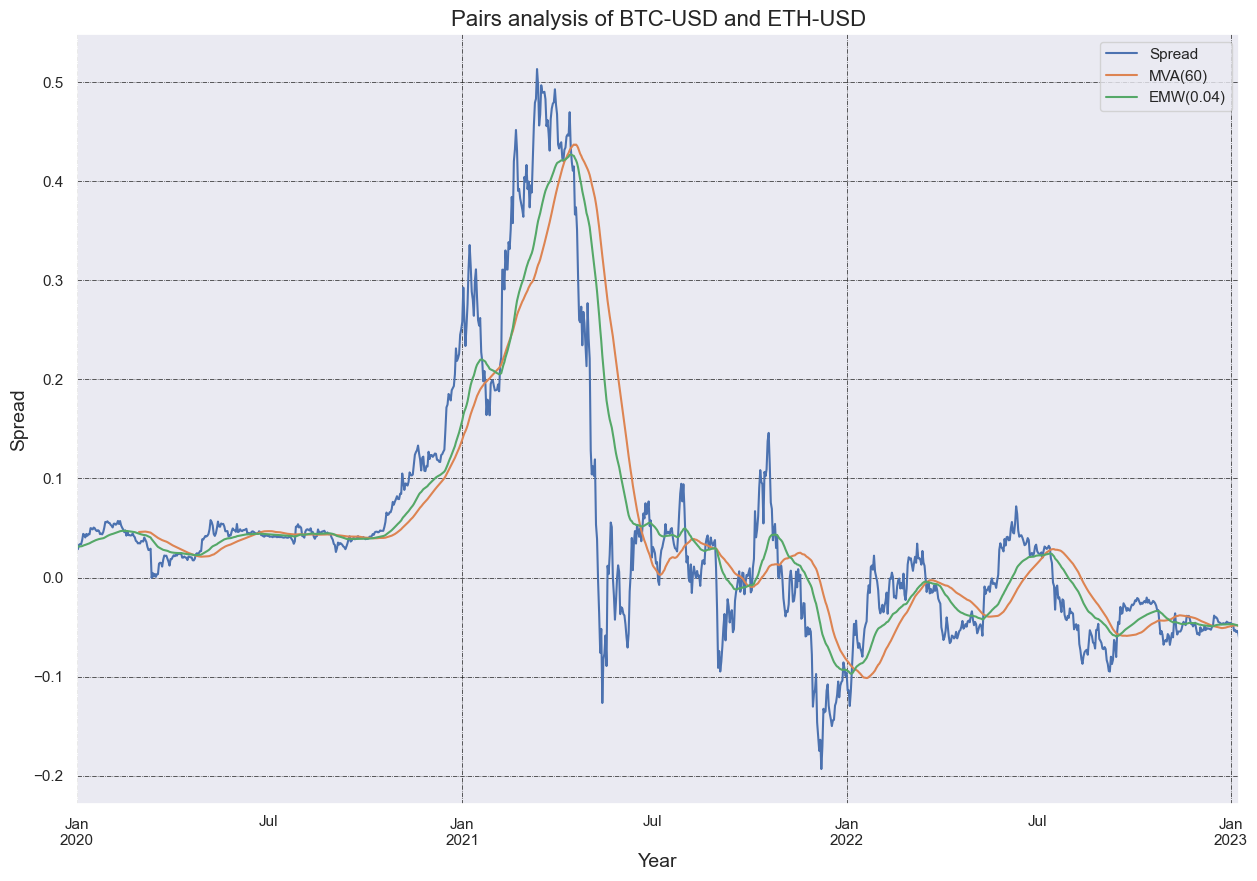

In [7]:


#  Given a pair of two assets, computes  the spread as well as  moving average and exponential moving average of the spread

def plotPairAnalysis(ticker1, ticker2, startDate,endDate):

    data = pd.DataFrame(columns=[ticker1, ticker2])
    tickers = [ticker1, ticker2]
    # Collect the data of both tickers and then normalize the data to the range [0,1] using MaxMin normalization
    for ticker in tickers:
        data[ticker] = yf.download(ticker, 
                                startDate,
                                endDate)['Adj Close']
        data[ticker + 'N'] = (data[ticker] - data[ticker].min()) / (data[ticker].max() - data[ticker].min())  

   
    # Compute the (linear) spread by taking the difference of the values
    data['Spread'] = data[ticker1 + 'N'] - data[ticker2 + 'N']
    # Compute moving average and exponential moving average
    data['MVA(60)'] = data['Spread'].rolling(window=60).mean() 
    data['EMW(0.04)'] = data['Spread'].ewm(alpha=0.04, adjust=False).mean()
    # Plot spread, moving average and exponential moving average in the same plot
    data[['Spread', 'MVA(60)','EMW(0.04)']].plot(figsize=(15, 10))
    # Show the legend
    plt.legend()
    # Define the label for the title of the figure
    plt.title("Pairs analysis of {} and {}".format(ticker1, ticker), fontsize=16)
    # Define the labels for x-axis and y-axis
    plt.ylabel('Spread', fontsize=14)
    plt.xlabel('Year', fontsize=14)
    # Plot the grid lines
    plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
    plt.show()




# Compate bitcoin and ethereum
tickers= ["BTC-USD", "ETH-USD"]

startDate = "2020-01-01"
endDate = "2023-01-10"


# Shoe the price of both BTC and ETH
plotPairAnalysis(tickers[0], tickers[1],startDate,endDate)